In [ ]:
"""
DeepDream

The DeepDream algorithm is almost identical to the convnet filter-visualization technique, consisting of running a convnet in reverse:
doing gradient ascent on the input to the convnet in order to maximize the activation of a specific filter in an upper layer of the convnet.
DeepDream uses this same idea, with a few simple differences:

-- With DeepDream, you try to maximize the activation of entire layers rather than that of a specific filter, thus mixing together
   visualizations of large numbers of features at once.
-- You start not from blank, slightly noisy input, but rather from an existing image — thus the resulting effects latch on to preexisting
   visual patterns, distorting elements of the image in a somewhat artistic fashion.
-- The input images are processed at different scales (called octaves), which improves the quality of the visualizations.
"""

In [1]:
"""
Implementing DeepDream in Keras

1. It starts from a convnet pretrained on ImageNet. In Keras, many such convnets are available: VGG16, VGG19, Xception, ResNet50, and
   so on. You can implement DeepDream with any of them, but your convnet of choice will naturally affect your visualizations, because
   different convnet architectures result in different learned features. The convnet used in the original DeepDream release was an
   Inception model, and in practice Inception is known to produce nice-looking DeepDreams.

2. For filter visualization, you tried to maximize the value of a specific filter in a specific layer. Here, you’ll simultaneously maximize
   the activation of all filters in a number of layers. Specifically, you’ll maximize a weighted sum of the L2 norm of the activations of
   a set of high-level layers. The exact set of layers you choose (as well as their contribution to the final loss) has a major influence
   on the visuals you’ll be able to produce, so you want to make these parameters easily configurable. Lower layers result in geometric
   patterns, whereas higher layers result in visuals in which you can recognize some classes from ImageNet.
"""
from tensorflow.keras.applications import inception_v3
from tensorflow.keras import backend as K


# You won’t be training the model, so this command disables all training-specific operations.
K.set_learning_phase(0)

"""
(1) load the pretrained inception v3 model
"""
model = inception_v3.InceptionV3(weights='imagenet', include_top=False)
print(model.summary())

"""
(2) start from a somewhat arbitrary configuration involving four layers
"""
# Dictionary mapping layer names to a coefficient quantifying how much the layer’s activation contributes to the loss to maximize.
layer_contributions = { 'mixed2': 0.2,
                        'mixed3': 3.,
                        'mixed4': 2.,
                        'mixed5': 1.5}

"""
(3) define a tensor that contains the loss: the weighted sum of the L2 norm of the activations of the layers in configuration
"""
layer_dict = dict([(layer.name, layer) for layer in model.layers])
loss = K.variable(0.)

for layer_name in layer_contributions:
    coeff = layer_contributions[layer_name]
    activation = layer_dict[layer_name].output
    scaling = K.prod(K.cast(K.shape(activation), 'float32'))
    # add the L2 norm of the features of a layer to the loss. You avoid border artifacts by only involving nonborder pixels in the loss.
    loss = loss + coeff * K.sum(K.square(activation[:, 2: -2, 2: -2, :])) / scaling
    
"""
(4) Gradient-ascent Process:
"""
# this tensor holds the generated image: the dream.
dream = model.input

# computes the gradients of the dream with regard to the loss
grads = K.gradients(loss, dream)[0]

# normalizes the gradients
grads /= K.maximum(K.mean(K.abs(grads)), 1e-7)

# sets up a Keras function to retrieve the value of the loss and gradients, given an input image
outputs = [loss, grads]
fetch_loss_and_grads = K.function([dream], outputs)

# function runs gradient ascent for a number of iterations
def eval_loss_and_grads(x):
    outs = fetch_loss_and_grads([x])
    loss_value = outs[0]
    grad_values = outs[1]
    return loss_value, grad_values

def gradient_ascent(x, iterations, step, max_loss=None):
    for i in range(iterations):
        loss_value, grad_values = eval_loss_and_grads(x)
        if max_loss is not None and loss_value > max_loss:
            break
        print('...Loss value at', i, ':', loss_value)
        x += step * grad_values
    return x


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
__________________________________________________________________________________________________
conv2d_1 (

In [4]:
"""
DeepDream algorithm (1)

1. Define a list of scales (also called octaves) at which to process the images. Each successive scale is larger than the previous one by
   a factor of 1.4 (it’s 40% larger): you start by processing a small image and then increasingly scale it up.

2. For each successive scale, from the smallest to the largest, you run gradient ascent to maximize the loss you previously defined, at
   that scale. After each gradient ascent run, you upscale the resulting image by 40%.

3. To avoid losing a lot of image detail after each successive scale-up (resulting in increasingly blurry or pixelated images), you can use
   a simple trick: after each scaleup, you’ll reinject the lost details back into the image, which is possible because you know what the
   original image should look like at the larger scale. Given a small image size S and a larger image size L, you can compute the difference
   between the original image resized to size L and the original resized to size S—this difference quantifies the details lost when going
   from S to L.
"""
# Auxiliary functions
import scipy
from tensorflow.keras.preprocessing import image

def resize_img(img, size):
    img = np.copy(img)
    factors = (1,
               float(size[0]) / img.shape[1],
               float(size[1]) / img.shape[2],
               1)
    return scipy.ndimage.zoom(img, factors, order=1)


def save_img(img, fname):
    pil_img = deprocess_image(np.copy(img))
    scipy.misc.imsave(fname, pil_img)


def preprocess_image(image_path):
    # Util function to open, resize and format pictures
    # into appropriate tensors.
    img = image.load_img(image_path)
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = inception_v3.preprocess_input(img)
    return img


def deprocess_image(x):
    # Util function to convert a tensor into a valid image.
    if K.image_data_format() == 'channels_first':
        x = x.reshape((3, x.shape[2], x.shape[3]))
        x = x.transpose((1, 2, 0))
    else:
        x = x.reshape((x.shape[1], x.shape[2], 3))
    x /= 2.
    x += 0.5
    x *= 255.
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [7]:
"""
DeepDream algorithm (2)

Layers that are lower in the network contain more-local, less-abstract representations and lead to dream patterns that look more geometric.
Layers that are higher up lead to more-recognizable visual patterns based on the most common objects found in ImageNet, such as dog eyes,
bird feathers, and so on. You can use random generation of the parameters in the layer_contributions dictionary to quickly explore many
different layer combinations.
"""
import numpy as np

step = 0.01  # Gradient ascent step size
num_octave = 3  # Number of scales at which to run gradient ascent
octave_scale = 1.4  # Size ratio between scales
iterations = 20  # Number of ascent steps per scale

# If our loss gets larger than 10,
# we will interrupt the gradient ascent process, to avoid ugly artifacts
max_loss = 10.

# Fill this to the path to the image you want to use
base_image_path = './data/deepdream/original_photo_deep_dream.jpg'

# Load the image into a Numpy array
img = preprocess_image(base_image_path)

# We prepare a list of shape tuples
# defining the different scales at which we will run gradient ascent
original_shape = img.shape[1:3]
successive_shapes = [original_shape]
for i in range(1, num_octave):
    shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
    successive_shapes.append(shape)
    
# Reverse list of shapes, so that they are in increasing order
successive_shapes = successive_shapes[::-1]
print(successive_shapes)

# Resize the Numpy array of the image to our smallest scale
original_img = np.copy(img)
shrunk_original_img = resize_img(img, successive_shapes[0])

for shape in successive_shapes:
    print('Processing image shape', shape)
    img = resize_img(img, shape)
    img = gradient_ascent(img,
                          iterations=iterations,
                          step=step,
                          max_loss=max_loss)
    upscaled_shrunk_original_img = resize_img(shrunk_original_img, shape)
    same_size_original = resize_img(original_img, shape)
    lost_detail = same_size_original - upscaled_shrunk_original_img

    img += lost_detail
    shrunk_original_img = resize_img(original_img, shape)
    save_img(img, fname='dream_at_scale_' + str(shape) + '.png')

save_img(img, fname='final_dream.png')

[(178, 178), (250, 250), (350, 350)]
Processing image shape (178, 178)
...Loss value at 0 : 0.6717842
...Loss value at 1 : 1.082643
...Loss value at 2 : 1.5439286
...Loss value at 3 : 2.0623746
...Loss value at 4 : 2.593142
...Loss value at 5 : 3.1628172
...Loss value at 6 : 3.7384703
...Loss value at 7 : 4.31285
...Loss value at 8 : 4.86998
...Loss value at 9 : 5.3566446
...Loss value at 10 : 5.877521
...Loss value at 11 : 6.3932595
...Loss value at 12 : 6.8773837
...Loss value at 13 : 7.423848
...Loss value at 14 : 7.910681
...Loss value at 15 : 8.41678
...Loss value at 16 : 8.7605715
...Loss value at 17 : 9.27046
...Loss value at 18 : 9.849173
Processing image shape (250, 250)


/data/home/zhangmu/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


...Loss value at 0 : 2.1936288
...Loss value at 1 : 3.5341947
...Loss value at 2 : 4.5813675
...Loss value at 3 : 5.4336934
...Loss value at 4 : 6.3170304
...Loss value at 5 : 7.0500035
...Loss value at 6 : 7.682406
...Loss value at 7 : 8.381304
...Loss value at 8 : 8.944307
...Loss value at 9 : 9.607675
Processing image shape (350, 350)
...Loss value at 0 : 2.2791333
...Loss value at 1 : 3.551183
...Loss value at 2 : 4.843156
...Loss value at 3 : 6.2099695
...Loss value at 4 : 8.087458


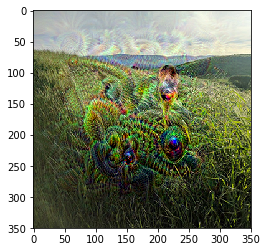

In [9]:
from matplotlib import pyplot as plt

plt.imshow(deprocess_image(np.copy(img)))
plt.show()